# Api et données spatio-temporelles avec Python

| Sujet | Auteur | Dernière Màj |
|:---:|:------:|:------------:|
| Api et données spatio-temporelles | Thomas LEYSENS (*IR AME*) | *23 Juin 2023* |


## Enjeux & Propositions
| Enjeu | Proposition |
|:------|:------------|
| Global | Montrer des exemples d'acquisition & de visualisation de données |
| Utiliser une Api | API températures de l'eau & API Geo communes|
| Requête OpenStreetMap | API Overpass (*OpenStreetMap*) |
| Cartographier des données | Utiliser les possibilités de base de GeoPandas |
| Représenter des données | Utilisation de la librairie Bokeh |
| Aperçu classe et méthode Python | Montrer rapidement des exemples de classes et méthodes Python |


> ***AVERTISSEMENT: CE TUTORIEL VISE A MONTRER CERTAINES POSSIBILITES D'ACQUISITION DE DONNEES VIA DES API ET PYTHON. IL NE CHERCHE PAS A APPRENDRE AUX NOVICES A CODER EN PYTHON (néanmoins, il contient du code réutilisable et peut aider les développeurs Python et/ou à présenter des opportunités pour les chercheurs/ingénieurs/techniciens et les curieux)***


## Introduction

Nous sommes en juin, il fait chaud. 

<img src="https://media.giphy.com/media/xT0Gqz4x4eLd5gDtaU/giphy.gif" alt="gif soleil" style="width: 30%;"/>

J'ai donc tout naturellement envie d'aller tremper mes pieds dans de l'eau fraiche. Et cela, n'importe où en France car j'ai la capacité de me téléporter (*j'ai découvert et maîtrisé un trou de ver mais, chuuuuuuut, c'est un secret, donc je ne peux pas vous expliquer le pourquoi du comment et, si la NSA vous demande, je n'existe pas !*). 

Vous me direz: il suffit de me rendre à une piscine du coin ou à un lac ou une rivière proche. 

Trop simple ! J'ai des exigences très précises, je ne laisse rien au hasard ! Je souhaite connaître l'heure propice pour une température idéale et je ne veux croiser personne car j'ai des pieds de Hobbit. Je souhaite également faire des randonnées en montagne, donc je veux obtenir des informations sur les chemins pédestres et les points d'eau potable.

Je veux donc avoir des données sur:
* la température au cours de la journée
* les chemins de randonnées et les points d'eau potable pour une zone précise

Et je veux pouvoir:
* obtenir ces données automatiquement
* changer mes requêtes au besoin
* réutiliser mes procédures
* visualiser les données
* ***me passer totalement de logiciels payants et propriétaires***
* ***utiliser des données open source et exploitables comme je le souhaite***

> Petit conseil, en passant, pour protéger votre vie privée et ne pas la donner entièrement aux GAFAM: vous pouvez utiliser des applications respectueuses de la vie privée (*et basées sur des données "libres" comme celles d'OpenStreetMap*) pour vous orienter (*notamment à pied et à vélo car la version voiture est encore en beta au moment où sont écrites ces lignes*) comme [Organic Maps](https://organicmaps.app/fr/) (*[lien App Store](https://apps.apple.com/app/organic-maps/id1567437057), [lien Google Play](https://play.google.com/store/apps/details?id=app.organicmaps&hl=fr), [lien F-Droid](https://f-droid.org/fr/packages/app.organicmaps/)*). Cette application peut fonctionner sans réseau mobile si vous avez téléchargé les données au préalable. Et ces données peuvent être plus précises, parfois, que celles des GAFAM, car ces dernières ne cartographient pas les lieux qui n'ont pas d'intérêt économique pour elles alors que les données OSM sont construites par des contributeurs volontaires partout dans le monde. 

Trêve de bavardages, allons chercher des données !

Une recherche rapide sur un moteur de recherche alternatif à Google (*car oui Google récupère également des informations sur vous de cette manière*) comme [DuckDuckGo](https://duckduckgo.com/) nous met sur la piste des données libres de [Hub'eau](https://hubeau.eaufrance.fr/) concernant les températures de l'eau et plus particulièrement cette [interface de programmation](https://hubeau.eaufrance.fr/page/api-temperature-continu#/temperature/) plus communément appelée API (*Application Programming Interface*), soit "*[...] un ensemble normalisé de classes, de méthodes, de fonctions et de constantes qui sert de façade par laquelle un logiciel offre des services à d'autres logiciels. Elle est offerte par une bibliothèque logicielle ou un service web, le plus souvent accompagnée d'une description qui spécifie comment des programmes « consommateurs » peuvent se servir des fonctionnalités du programme « fournisseur ».*" (*source: [Wikipedia](https://fr.wikipedia.org/wiki/Interface_de_programmation)*)

## Récupérer une bounding box pour obtenir la liste complète des stations

Lorsqu'on explore la documentation de l'API "températures" de Hub'eau, on constate qu'il est possible d'obtenir une liste des stations à partir d'une zone géographique (*appelée ```bbox```, contraction de bounding box*)

![hubeau base](../img/api/hubeau_temp_presentation.png)

![hubeau stations](../img/api/temp_station_base.png)

Nous avons donc besoin de valeurs pour cette bounding box. Il faut noter que la projection des coordonnées doit être **WGS84 (*EPSG 4326*)**. Nous ne détaillerons pas ici les projections cartographiques mais, si cela vous intéresse, commencez par lire [cette page Wikipedia](https://fr.wikipedia.org/wiki/Projection_cartographique) et/ou [celle-ci](https://fr.wikipedia.org/wiki/Syst%C3%A8me_de_coordonn%C3%A9es_(cartographie)).

Pour obtenir ces valeurs, il existe, entre autres, des outils comme le [Tile Calculator](https://tools.geofabrik.de/calc/#type=geofabrik_standard&bbox=5.538062,47.236312,15.371071,54.954937&tab=1&proj=EPSG:4326&places=4) de Geofabrik.

![tile calculator](../img/tile_calc.png)

Ensuite, nous allons utiliser la librairie Python [Requests](https://docs.python-requests.org/en/latest/index.html) pour interroger l'API avec des paramètres précis et obtenir des données au format [GeoJSON](https://en.wikipedia.org/wiki/GeoJSON). 

Nous allons utiliser une [requête de type ```GET```](https://developer.mozilla.org/fr/docs/Learn/Forms/Sending_and_retrieving_form_data#lattribut_method).

Pour ce faire, la méthode ```get``` de ```requests``` demande une URL ainsi que des paramètres (*correspondant aux paramètres proposés par l'API Températures de Hub'eau*):
* ```url```: "https://hubeau.eaufrance.fr/api/v1/temperature/station"
* paramètres:
    * ```bbox```: [-1.8888, 42.3218, 7.7906, 46.441] *=> obtenue depuis l'outil Tile Calculator et formatée correctement*
    * ```format```: "geojson" *=> on souhaite obtenir des données au format GeoJSON*

In [1]:
import requests

url = "https://hubeau.eaufrance.fr/api/v1/temperature/station"
bbox = [-1.8888, 42.3218, 7.7906, 46.441]
params = {
    "bbox":bbox,
    "format":"geojson"
}
response = requests.get(
    url,
    params=params
)

Une fois la requête exécutée, vérifions que tout s'est bien passé en consultant le ```status_code```

In [2]:
response.status_code

200

Le code ```200``` indique qu'aucune erreur ne s'est produite.

> ***Attention cela ne signifie pas pour autant qu'il y a un résultat valide. Ce code peut s'accompagner d'un résultat "vide" si la requête n'a engendré aucune erreur mais que les paramètres de celle-ci ne correspondent à aucune donnée***

Jetons un oeil aux 2 premiers résultats en consultant la partie ```features``` de la réponse (*elle a la structure d'une liste de dictionnaires au sens Python*):

In [3]:
response.json()["features"][:2]

[{'type': 'Feature',
  'properties': {'altitude': 456.0,
   'code_cours_eau': 'V1230560',
   'code_bassin': None,
   'latitude': 45.78876059022991,
   'libelle_cours_eau': None,
   'libelle_sous_bassin': None,
   'code_commune': '74104',
   'code_sous_bassin': None,
   'code_region': '84',
   'code_type_projection': 26,
   'code_troncon_hydro': 'V1230560',
   'coordonnee_x': 950959.0,
   'coordonnee_y': 6526151.0,
   'longitude': 6.231161741514297,
   'uri_masse_eau': 'http://id.eaufrance.fr/MasseDEauRiviere_VEDL2019/DR535',
   'libelle_departement': 'Haute-Savoie',
   'libelle_station': 'EAU MORTE A DOUSSARD 2',
   'code_departement': '74',
   'uri_station': 'https://id.eaufrance.fr/StationMesureEauxSurface/06830079',
   'localisation': 'Pont D 909a',
   'code_masse_eau': 'DR535',
   'code_station': '06830079',
   'uri_bassin': None,
   'libelle_bassin': None,
   'date_maj_infos': '2022-12-16',
   'libelle_commune': 'Doussard',
   'uri_cours_eau': 'https://id.eaufrance.fr/CoursEau_Car

Nous avons bien obtenu des stations avec leurs différentes propriétés dont la localisation (*dans les parties ```geometry```*). 

Mais ce n'est pas facilement lisible et exploitable. Transformons donc ces résultats en tableau et, plus précisément, en [GeoDataFrame](https://geopandas.org/en/stable/). 

In [4]:
import geopandas as gpd

gdf_stations = gpd.GeoDataFrame.from_features(
    response.json()["features"]
).set_crs(
    epsg=4326
)
gdf_stations

geometry  altitude code_cours_eau code_bassin   latitude  \
0    POINT (6.23116 45.78876)     456.0       V1230560        None  45.788761   
1    POINT (5.89307 44.73682)    1036.0       W2210500        None  44.736818   
2    POINT (4.53664 45.41307)     588.0       V31-0400        None  45.413072   
3    POINT (5.69218 45.01776)     351.0       W2--0200        None  45.017756   
4    POINT (6.30392 45.04346)    1428.0       W27-0400        None  45.043456   
..                        ...       ...            ...         ...        ...   
348  POINT (4.15590 45.49659)       0.0       K06-0310        None  45.496587   
349  POINT (4.52558 45.62799)       0.0       K06-0330        None  45.627989   
350  POINT (4.11411 45.28556)       0.0       K05-0300        None  45.285563   
351  POINT (3.89092 45.37977)       0.0       K05-0300        None  45.379774   
352  POINT (4.33156 45.22006)       0.0       K0454000        None  45.220056   

    libelle_cours_eau libelle_sous_bassin code_commune code_sous_bassin  \
0                None                None        74104             None   
1                None                None        05139             None   
2                None                None        42322             None   
3                None                None        38545             None   
4                None                None        05063             None   
..                ...                 ...          ...              ...   
348              None                None        42256             None   
349              None                None        69110             None   
350              None                None        43025             None   
351              None                None        63412             None   
352              None                None        43087             None   

    code_region  ...  code_masse_eau code_station  uri_bassin  libelle_bassin  \
0            84  ...           DR535     06830079        None            None   
1            93  ...           DR348     06820164        None            None   
2            84  ...          DR2019     06820138        None            None   
3            84  ...           DR337     06820118        None            None   
4            93  ...           DR336     06820089        None            None   
..          ...  ...             ...          ...         ...             ...   
348          84  ...          GR0166     04009350        None            None   
349          84  ...         GR0167A     04009050        None            None   
350          84  ...         GR0163B     04003900        None            None   
351          84  ...         GR0163A     04003645        None            None   
352          84  ...          GR0162     04003355        None            None   

     date_maj_infos           libelle_commune  \
0        2022-12-16                  Doussard   
1        2022-12-16                   Dévoluy   
2        2022-12-16          La Valla-en-Gier   
3        2022-12-16                       Vif   
4        2022-12-16                  La Grave   
..              ...                       ...   
348      2013-05-27  Saint-Marcellin-en-Forez   
349      2013-05-27                 Larajasse   
350      2009-10-23                   Beauzac   
351      2013-02-19              Sauvessanges   
352      2010-06-07                  Dunières   

                                         uri_cours_eau        pk  \
0    https://id.eaufrance.fr/CoursEau_Carthage2017/...       NaN   
1    https://id.eaufrance.fr/CoursEau_Carthage2017/...       NaN   
2    https://id.eaufrance.fr/CoursEau_Carthage2017/...       NaN   
3    https://id.eaufrance.fr/CoursEau_Carthage2017/...       NaN   
4    https://id.eaufrance.fr/CoursEau_Carthage2017/...       NaN   
..                                                 ...       ...   
348  https://id.eaufrance.fr/CoursEau_Carthage2017/...  979748.0   
349  https://id.eaufrance.fr/CoursEau_Car

Les données au format ```GeoDataFrame``` sont plus facilement exploitables, manipulables et peuvent être enregistrées sous différements formats (*```GeoPackage```, ```GeoJSON```, ```Shapefiles```*) lisibles sous [QGIS](https://www.qgis.org/en/site/). Les géométries peuvent être - si besoin - transformées et exportées au format ```CSV``` pour être lues dans un logiciel de tableurs externe. 

On peut également les visualiser dans l'espace dans une carte interactive au sein de ce Notebook en utilisant la [méthode ```explore```](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html)

In [5]:
gdf_stations.explore(
    color="red",
    marker_kwds={
        "radius":5
    },
    tiles="Stamen Terrain"
)

## Choix d'un numéro de station

En zoomant du côté de la région Rhône-Alpes, nous survolons le cercle rouge dans la commune de Saint-Christophe-en-Oisans, ce qui nous permet d'obtenir une popup et de récupérer le ```code_station``` (*il faut noter que nous pourrions également obtenir cette information en parcourant ou filtrant le GeoDataFrame mais il s'agit ici de montrer les possibilités d'exploration visuelle et cartographique*). 

![zoom](../img/api/zoom_station.png)

Ce code va nous permettre de récupérer les mesures de températures au sein de cette station via l'API température. 

![température base](../img/api/temp_base.png)

Nous allons récupérer des données sur une année pour avoir une estimation (*très grossière car l'idée n'est pas d'être précis mais de montrer les possibilités*) de la période "idéale" pour avoir une eau à une température souhaitée. 

Pour cela, nous allons utiliser les paramètres - proposés par l'API - suivants:
* ```date_debut_mesure``` 
    * ![date début mesure](../img/api/temp_date_debut.png)
* ```date_fin_mesure``` 
    * ![date fin mesure](../img/api/temp_date_fin.png)
* ```code_station``` 
    * ![code station](../img/api/temp_code_station.png)
* ```size``` 
    * ![size](../img/api/temp_size.png)
* ```format``` 
    * ![format](../img/api/temp_format.png)

## Création d'une classe et d'une méthode Python

Afin d'être plus efficace et de créer du code réutilisable, il convient de créer des classes et des méthodes Python. J'ai donc créé du code paramétrable dans un nouveau module Python importable dans ce Notebook. Nous n'aborderons pas le développement de code Python dans ce tutoriel, mais vous pouvez consulter/utiliser/modifier librement le [module ```api_request.request```](https://github.com/thomleysens/Tutoriels_AME/blob/233778575caf3efca3f0a2088de1d9020f325b71/api_request/request.py) si vous le souhaitez, étant donné la license BSD 3-Clause du dépôt. 

Nous importons la classe ```GdfFromApi``` du module ```api_request.request```. Cette classe permet de faire une requête GET avec des paramètres précis et d'obtenir un GeoDataFrame avec les résultats. 

In [6]:
# Exécuter cette cellule pour avoir accès au module local api_request

import os
import sys

module_path = os.path.abspath(
    os.path.join(
        ".."
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)

In [7]:
from api_request.request import GdfFromApi #import de la classe

base_url = "https://hubeau.eaufrance.fr/api"
sub_url = "/v1/temperature/chronique"

params = {
    "date_debut_mesure":"2015-01-01",
    "date_fin_mesure":"2015-12-31",
    "code_station":"06143650",
    "size":20000,
    "format":"geojson"
}

# Instanciation de la classe
get_api = GdfFromApi(base_url)

# Exécution de la méthode get
gdf_temperature = get_api.get(
    sub_url,
    params
)
print (
    "Status code: {}".format(
        get_api.status_code
    )
)

gdf_temperature

Status code: 200


geometry                     libelle_station  \
0     POINT (6.15485 44.96755)  VENEON A ST-CHRISTOPHE-EN-OISANS 1   
1     POINT (6.15485 44.96755)  VENEON A ST-CHRISTOPHE-EN-OISANS 1   
2     POINT (6.15485 44.96755)  VENEON A ST-CHRISTOPHE-EN-OISANS 1   
3     POINT (6.15485 44.96755)  VENEON A ST-CHRISTOPHE-EN-OISANS 1   
4     POINT (6.15485 44.96755)  VENEON A ST-CHRISTOPHE-EN-OISANS 1   
...                        ...                                 ...   
8754  POINT (6.15485 44.96755)  VENEON A ST-CHRISTOPHE-EN-OISANS 1   
8755  POINT (6.15485 44.96755)  VENEON A ST-CHRISTOPHE-EN-OISANS 1   
8756  POINT (6.15485 44.96755)  VENEON A ST-CHRISTOPHE-EN-OISANS 1   
8757  POINT (6.15485 44.96755)  VENEON A ST-CHRISTOPHE-EN-OISANS 1   
8758  POINT (6.15485 44.96755)  VENEON A ST-CHRISTOPHE-EN-OISANS 1   

     code_cours_eau                                        uri_station  \
0          W2730500  https://id.eaufrance.fr/StationMesureEauxSurfa...   
1          W2730500  https://id.eaufrance.fr/StationMesureEauxSurfa...   
2          W2730500  https://id.eaufrance.fr/StationMesureEauxSurfa...   
3          W2730500  https://id.eaufrance.fr/StationMesureEauxSurfa...   
4          W2730500  https://id.eaufrance.fr/StationMesureEauxSurfa...   
...             ...                                                ...   
8754       W2730500  https://id.eaufrance.fr/StationMesureEauxSurfa...   
8755       W2730500  https://id.eaufrance.fr/StationMesureEauxSurfa...   
8756       W2730500  https://id.eaufrance.fr/StationMesureEauxSurfa...   
8757       W2730500  https://id.eaufrance.fr/StationMesureEauxSurfa...   
8758       W2730500  https://id.eaufrance.fr/StationMesureEauxSurfa...   

       latitude libelle_cours_eau code_station code_commune  resultat  \
0     44.967547              None     06143650        38375     0.051   
1     44.967547              None     06143650        38375     0.051   
2     44.967547              None     06143650        38375     0.051   
3     44.967547              None     06143650        38375     0.051   
4     44.967547              None     06143650        38375     0.051   
...         ...               ...          ...          ...       ...   
8754  44.967547              None     06143650        38375     3.327   
8755  44.967547              None     06143650        38375     3.327   
8756  44.967547              None     06143650        38375     3.327   
8757  44.967547              None     06143650        38375     3.301   
8758  44.967547              None     06143650        38375     3.301   

     code_parametre code_unite             libelle_commune code_qualification  \
0              1301         27  Saint-Christophe-en-Oisans                  4   
1              1301         27  Saint-Christophe-en-Oisans                  4   
2              1301         27  Saint-Christophe-en-Oisans                  4   
3              1301         27  Saint-Christophe-en-Oisans                  4   
4              1301         27  Saint-Christophe-en-Oisans                  4   
...             ...        ...                         ...                ...   
8754           1301         27  Saint-Christophe-en-Oisans                  4   
8755           1301         27  Saint-Christophe-en-Oisans                  4   
8756           1301         27  Saint-Christophe-en-Oisans                  4   
8757           1301         27  Saint-Christophe-en-Oisans                  4   
8758           1301         27  Saint-Christophe-en-Oisans                  4   

     libelle_qualification date_mesure_temp  \
0             Non qualifié       2015-01-01   
1             Non qualifié       2015-01-01   
2             Non qualifié       2015-01-01   
3             Non qualifié       2015-01-01   
4             Non qualifié       2015-01-01   
...                    ...              ...   
8754          Non qualifié       2015-12-31   
8755          Non qualifié       2015-12-31   
8756          Non q

* Les températures sont effectuées par heure et sont nombreuses. 
* Le champ contenant les dates ```date_mesure_temp``` et le champ contenant les heures ```heure_mesure_temp``` sont séparés et sont au format ```string```. Il est donc nécessaire de les regrouper et de les transformer en [```datetime```](https://docs.python.org/fr/3/library/datetime.html) pour que cela soit plus pratique à exploiter et à visualiser. 

In [8]:
from datetime import datetime

# Désactiver des avertissements qui n'ont pas lieu d'être ici
gpd.pd.options.mode.chained_assignment = None 

# Regroupements des champs "date_mesure_temp" et "heure_mesure_temp"
gdf_temperature["datetime"] = gdf_temperature.apply(
    lambda x: "{} {}".format(
        x["date_mesure_temp"],
        x["heure_mesure_temp"]
    ),
    axis=1
)

# Application de la transformation en datetime
gdf_temperature["datetime"] = [
    datetime.strptime(
        x, 
        "%Y-%m-%d %H:%M:%S"
    ) for x in gdf_temperature[
        "datetime"
    ]
]

# Observation des 3 premiers résultats du nouveau champ
gdf_temperature["datetime"].head(3)

0   2015-01-01 00:00:00
1   2015-01-01 01:00:00
2   2015-01-01 02:00:00
Name: datetime, dtype: datetime64[ns]

## Représenter/visualiser les résultats

Observons les résultats sous forme de graphique afin d'en avoir une approche plus globale et visuelle.

### Version simple et statique

Essayons tout d'abord une visualisation statique en utilisant la [méthode ```plot``` de GeoPandas](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html)

<Axes: title={'center': 'Températures (Celsius) à la station VENEON A ST-CHRISTOPHE-EN-OISANS 1'}, xlabel='Date & heure de la mesure', ylabel='Température en degrés Celsius'>

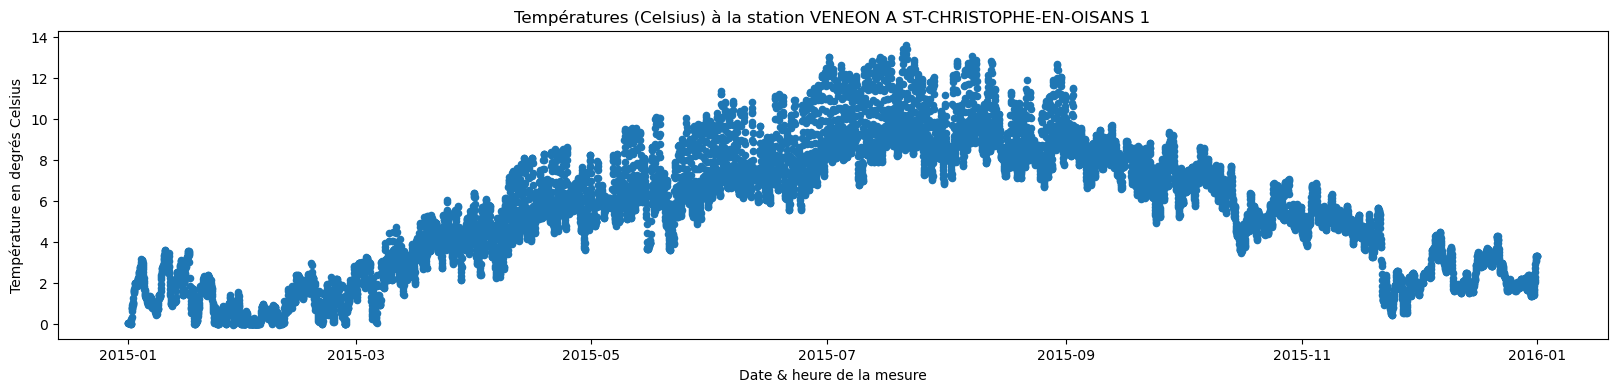

In [9]:
# Détermination du titre en récupérant la première valeur
# observée dans le champ "libelle_station"
title = "Températures (Celsius) à la station {}".format(
    gdf_temperature["libelle_station"][0]
)

# Titre de l'axe Y
ylabel = "Température en degrés Celsius"

# Titre de l'axe X
xlabel = "Date & heure de la mesure"

# Création du graphique
gdf_temperature.plot(
    x="datetime",   # champ pour X
    y="resultat",   # champ pour Y
    kind="scatter", # forme 
    figsize=(20,4), # largeur et hauteur en pouces
    title=title,    # titre
    ylabel=ylabel,  # label Y
    xlabel=xlabel   # label X
)

Cette version statique est un premier pas mais elle est limitée si l'on souhaite obtenir des détails. 

Passons donc à une version améliorée et interactive. 

### Version plus développée et interactive

Pour ce faire, nous utilisons la librairie [Bokeh](https://docs.bokeh.org/en/latest/docs/gallery.html) dans sa version Python. 

Nous n'entrerons pas dans les détails, mais voici quelques liens sur les méthodes et outils utilisés:

* ```colormapper``` voir [cet exemple](https://docs.bokeh.org/en/latest/docs/examples/basic/data/color_mappers.html)
* ```DatetimeTickFormatter```, voir [la documentation](https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html#bokeh.models.DatetimeTickFormatter)
* ```color_bar```, voir [cet exemple](https://docs.bokeh.org/en/latest/docs/examples/basic/data/linear_cmap_colorbar.html)
* Hover tool, voir [cet exemple](https://docs.bokeh.org/en/latest/docs/examples/interaction/tools/hover_tooltips.html)

#### Aperçu rapide des outils de la figure

![bokeh tools](../img/bokeh_tools.png)

In [10]:
import math
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.transform import linear_cmap
from bokeh.models import DatetimeTickFormatter, HoverTool, ColumnDataSource

output_notebook() # Obtenir la sortie graphique au sein du notebook

# Paramètres de la figure (en reprenant certains éléments précédents)
p = figure(
    width=1050, # largeur en pixels
    height=600, # hauteur en pixels
    title=title,
    y_axis_label=ylabel,
    x_axis_label=xlabel
)

# Création d'une table linéaire de couleurs
cmap = linear_cmap(
    "resultat",                            # Champ des valeurs
    palette="Plasma256",                   # Choix palette
    low=gdf_temperature["resultat"].min(), # Minimum 
    high=gdf_temperature["resultat"].max() # Maximum
)

# Création de la source pour le graphique
# soit le GeoDataFrame sans la géométrie
source = ColumnDataSource(
    gdf_temperature.drop(
        columns=["geometry"]
    )
)

# Ajout de points pour chaque mesure/résultat
c = p.circle(
    "datetime",    # Champ pour X
    "resultat",    # Champ pour Y
    source=source, # Source
    color=cmap     # Couleur déterminée par la table de couleur
)

# Construction d'une barre de couleur basée sur les glyphes précédents 
color_bar = c.construct_color_bar(width=20)

# Ajout de cette barre à la figure
p.add_layout(color_bar, "right")

# Formatage de l'axe X pour représenter correctement les dates
p.xaxis.formatter = DatetimeTickFormatter(
    minutes="%Y-%m-%d %H:%M:%S",
    hours="%Y-%m-%d %H:%M:%S",
    days="%Y-%m-%d",
    months="%Y-%m-%d",
    years="%Y-%m-%d"
)

# Création et ajout de l'outil de survol (hover)
hover = HoverTool(
    tooltips = [
        ("Date", "@datetime{%Y-%m-%d %H:%M:%S}"),
        ("Température", "@resultat")
    ],
    formatters={
        "@datetime": "datetime"
    },
)
p.add_tools(hover)

# Orientation du champ X pour plus de lisibilité
p.xaxis.major_label_orientation = math.pi/4

# Visualisation
show(p)

Loading BokehJS ...

### Trouver la période pour une température "idéale"

Pour faire cette estimation très grossière, nous allons:
* déterminer une valeur de température **minimale**
* déterminer une valeur de température **maximale**
* filtrer le GeoDataFrame en fonction de ces 2 valeurs
* déterminer l'heure médiane
* obtenir la date minimale et la date maximale pour cette heure médiane
* présenter un résultat

In [11]:
import locale
from statistics import median

# Fixer les locales (pour obtenir des dates au format "français")
locale.setlocale(locale.LC_TIME, "fr_FR.UTF-8")

# Déterminer la température minimale et la température maximale
min_temp = 11.5
max_temp = 12

# Filtrer le GeoDataFrame et retenir la Série "datetime"
times = gdf_temperature.loc[
    (
        gdf_temperature["resultat"]>=min_temp
    ) & (
        gdf_temperature["resultat"]<=max_temp
    )
]["datetime"]

# Déterminer l'heure médiane
perfect_hour = median(
    [
        x.time() for x in times 
    ]
)

# Récupérer la date "minimale" et la date "maximale"
min_date = times.min()
max_date = times.max()

# Présenter le résultat
print (
    """
    En se basant sur les données récoltées entre {} et {}, 
    l'heure idéale médiane pour avoir une température comprise 
    entre {}°C et {}°C est: {} entre le {} et le {}
    """.format(
        params[
            "date_debut_mesure"
        ],
        params[
            "date_fin_mesure"
        ],
        min_temp,
        max_temp,
        perfect_hour.strftime(
            "%Hh%M"
        ),
        min_date.strftime(
            "%d %B"
        ),
        max_date.strftime(
            "%d %B"
        )
    )
)


    En se basant sur les données récoltées entre 2015-01-01 et 2015-12-31, 
    l'heure idéale médiane pour avoir une température comprise 
    entre 11.5°C et 12°C est: 17h00 entre le 28 juin et le 30 août
    


Nous savons désormais quand il faut nous rendre à la station choisie pour obtenir la température idéale que nous avons déterminée. 

Néanmoins, cela ne suffit pas car nous avons besoin de connaître les chemins pédestres (*de randonnée*) dans la commune ainsi que les points d'eau potable. 

## Récupérer les chemins et les points d'eau

Pour obtenir ces données, il est nécessaire de déterminer une zone de recherche (*bounding box*).

### Obtenir la bounding box de la commune

Pour ce faire, utilisons une autre API, [l'API Geo](https://api.gouv.fr/documentation/api-geo), toujours avec la classe Python ```GdfFromApi``` (*nous pourrions utiliser l'outil Tile Calculator une nouvelle fois mais il s'agit ici d'explorer rapidement une autre API pour multiplier les exemples*). 

In [12]:
from api_request.request import GdfFromApi

# URL de base
base_url = "https://geo.api.gouv.fr"

# Complément URL
sub_url = "/communes"

# Paramètres pour la requête sous forme de dictionnaire
params = {
    "nom":gdf_temperature["libelle_commune"][0],
    "fields":"code,bbox",
    "format":"geojson",
    "geometry":"bbox"
}

# Instanciation de la classe
get_api = GdfFromApi(base_url)

# Exécuter la requête pour récupérer un GeoDataFrame
# des résultats
gdf_commune = get_api.get(
    sub_url,
    params
)

print (
    
    "Status code: {}".format(
        get_api.status_code
    )
)

# Cartographie de la bounding box
gdf_commune.explore(
    tiles="Stamen Terrain"
)

Status code: 200


### Récupérer les points d'eau et les chemins pédestres dans la bounding box de la commune

> ***AVERTISSEMENT: nous récupérons des données pour effectuer des tests et présenter des exemples, ne vous basez par sur celles-ci pour prévoir une expédition en montagne !***

Une classe Python ```GetNodeWay``` a été créée. Elle utilise l'API d'[Overpass](https://wiki.openstreetmap.org/wiki/FR:Overpass_API) qui permet d'effectuer des requêtes afin d'obtenir des données d'[OpenStreetMap](https://www.openstreetmap.org/) et de retourner un GeoDataFrame. Cette classe fait partie du [module ```api_request.request```](https://github.com/thomleysens/Tutoriels_AME/blob/233778575caf3efca3f0a2088de1d9020f325b71/api_request/request.py). 

Nous avons besoin:
* d'une bounding box
* de [tags](https://wiki.openstreetmap.org/wiki/FR:Attributs) OpenStreetMap, donc d'un ensemble de clés / valeurs

Nous devons:
* déterminer la bounding box depuis le polygone de la commune
* trouver les tags adéquats pour obtenir les chemins pédestres
* exécuter la requête pour obtenir un GeoDataFrame
* séparer les points (*points d'eau potable*) des lignes (*chemins pédestres*)
* cartographier:
    * les points d'eau potable
    * les chemins pédestres
    * la station de températures de l'eau

In [13]:
import folium

from api_request.request import GetNodeWay, bbox_from_poly

# Création de la bounding box
bbox = bbox_from_poly(
    gdf_commune["geometry"][0]
)

# Instanciation de la classe
overpass = GetNodeWay()

# Tuple de tuples clé/valeur OSM
tags = (
    ("route","hiking"),
    ("route","foot"),
    ("highway","track"),
    ("highway","path"),
    ("amenity","drinking_water")
)

# Exécution de la requête
gdf = overpass.get(bbox, tags)

# Séparer les points et les lignes
points = gdf.copy().loc[
    gdf["type"]=="node"
]
ways = gdf.copy().loc[
    gdf["type"]=="way"
]

# Cartographier les lignes
m = ways.explore(
    color="red",
    tooltip=[
        "tags.highway", 
        "tags.tracktype", 
        "tags.route"
    ],
    legend=True,
    name="Chemins pédestres",
    tiles="Stamen Terrain"
)

# Cartographier les points
points.explore(
    m=m,
    marker_kwds={
        "radius":5
    },
    color="blue",
    tooltip=[
        "tags.amenity",
        "lat",
        "lon"
    ],
    legend=True,
    name="Fontaines eau potable"
)

# Cartographier la station
station  = gdf_temperature.iloc[[0]][
    [
        "libelle_station",
        "latitude",
        "longitude",
        "libelle_commune",
        "code_station",
        "geometry"
    ]
]
station.explore(
    m=m,
    tooltip=[
        "libelle_station",
        "latitude",
        "longitude",
        "libelle_commune",
        "code_station"
    ],
    marker_kwds={
        "radius":10
    },
    color="black",
    legend=True,
    name="Station température"
)

# Ajouter un contrôle des couches dans la légende
folium.LayerControl().add_to(m)
m

## Licenses librairies Python / Données / API

### Données & API

| API / Données | License / Droit d'usage | Documentation |
|:--------------|:------------------------|:--------------|
| [Hub'eau températures](https://hubeau.eaufrance.fr/page/api-temperature-continu) | [License ouverte interministérielle](https://www.etalab.gouv.fr/licence-ouverte-open-licence) & [FAQ](https://assistance.brgm.fr/hubeau/quels-sont-droits-dusage-donnees-proposees-apis) | [Lien](https://hubeau.eaufrance.fr/page/api-temperature-continu) |
| [API Geo](https://api.gouv.fr/documentation/api-geo) | [License ouverte interministérielle](https://www.etalab.gouv.fr/licence-ouverte-open-licence) | [Lien](https://api.gouv.fr/documentation/api-geo) |
| [Overpass](https://wiki.openstreetmap.org/wiki/FR:Overpass_API) & [OpenStreetMap](https://www.openstreetmap.org/) | [Copyright](https://www.openstreetmap.org/copyright), [License Open Data Commons Open Database License (ODbL)](https://opendatacommons.org/licenses/odbl/) | [Documentation Overpass](https://dev.overpass-api.de/overpass-doc/fr/) |

### Librairies Python

Voir le [README](https://github.com/thomleysens/Tutoriels_AME/tree/main#librairies-python-utilis%C3%A9es-dans-ce-d%C3%A9p%C3%B4t).